In [7]:
# Physics Thesis Code for Calculating fusion rate 
# Author: Jacob van de Lindt 
# July 17th, 2019

# Using Guess's Law

import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [3]:
# Initialize Physical Dimensions of the Machine

R_cathode = 1
R_anode = 2
R_mag = 1.25

R_coil = .04
R_alloy = .01
R_steel = .01
R_stalk = .06

# Specify Physical constants 

mu_o = 1
epsi_o = 1
k = 1
e = 1
m_dueterium  = 2.014
m_neutron = 1.008664
m_proton = 1.007276
m_electron = 0.00054858

#Specify Tunable metrics:

I = 20 # [A]
V_grid = -10 # [V]
V_anode = 0 # [V]
Q_grid = -1000 # [C]
Amp = 500


In [4]:
# Define Position Space
dr = .02
dt = dr
r_vec = np.arange(0, R_anode*2, dr)


In [5]:
# Charge Density Initialization
def rho_init(r, period, Amplitude):
    return Amplitude*np.cos((np.pi/2*r) / period) * e * 0
    

# Electric Field Helper Function
def E_grids(R):
    if R > R_cathode:
        return Q_grid / (4 * np.pi * epsi_o * R**2)
    else:
        return 0
v_E_grids = np.vectorize(E_grids)

# Electric Field Function:
def E_r(R):
    E_vec = np.zeros(R.shape[0])
    period = np.max(R)
    for index in range(E_vec.shape[0]):
        integral = 0
        r_top = R[index]
        for r in np.arange(0, r_top + dr, dr):
            integral = integral + ((r**2 * rho_init(r, period, Amp)) / epsi_o) * dr  
        E_vec[index] = (integral / r_top**2) + v_E_grids(r_top)
    
    return E_vec

def Phi_r(R_vec, E_vec):
    Phi_vec = np.zeros(R_vec.shape[0])
    Phi_o = 20
    for index in range(Phi_vec.shape[0]):
        integral = 0
        for r in np.arange(0, R_vec[index] + dr, dr):
            r_index = np.where(R_vec == r)
            integral = integral + E_vec[r_index] * dr
        
        Phi_vec[index] = Phi_o - integral
    return Phi_vec
       
    

C:\Users\jacob\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


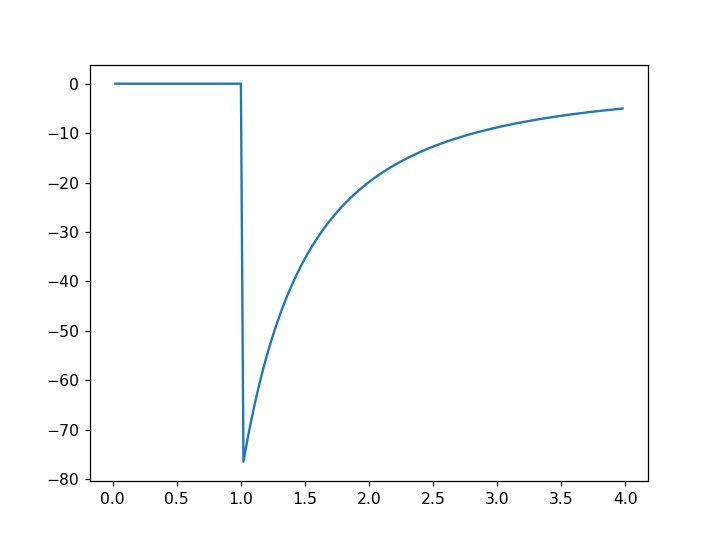

In [8]:
E_vec = E_r(r_vec)
plt.plot(r_vec, E_vec)
plt.show()
# artifically test
E_vec[0] = 0


<IPython.core.display.Javascript object>


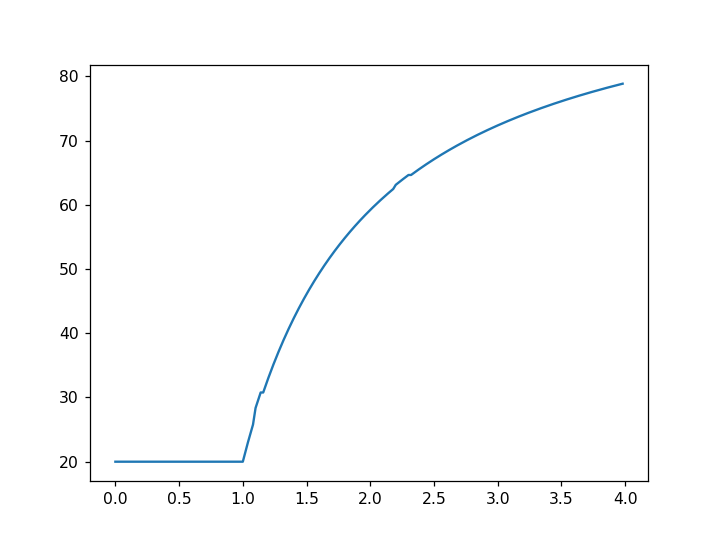

In [9]:
Phi_vec = Phi_r(r_vec, E_vec)
plt.plot(r_vec, Phi_vec)
plt.show()
#print(Phi_vec)

<IPython.core.display.Javascript object>


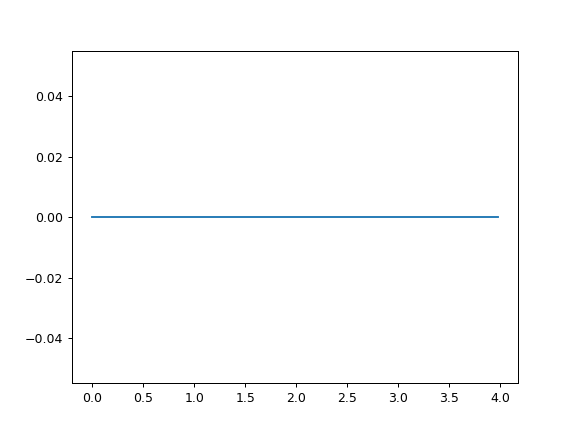

In [165]:
plt.plot(r_vec, rho_init(r_vec, np.max(r_vec), Amp))
plt.show()

In [166]:
def get_E_and_close_pos(pos, r_vec, E_vec):
    index = -1 # Temperary holder
    if pos <= np.max(r_vec):
        for i in range(r_vec.shape[0]):
            if ( (pos > r_vec[i]) and (pos < r_vec[i + 1]) ):
                index = np.where(r_vec == r_vec[i])
                break
            elif pos == r_vec[i]:
                index = np.where(r_vec == r_vec[i])
                break
            elif pos == r_vec[i + 1]:
                index = np.where(r_vec == r_vec[i + 1])
                break
    
    else:
        print('The particle has left the domain')
    E = E_vec[index]
    close_pos = r_vec[index]
    print(index)
    return E, close_pos, index[0][0]

def loss_channel_check(pos):
    transparancy = .99
    collision_type = 'none'
    is_active_2 = True
    # Check for a collision with the anode
    n = 3 # the number of dr steps away from the grid that a grid collision needs to be considered
    if (pos > (R_anode - n*dr)) and (pos < (R_anode + n*dr) ):
        prob = 1 - transparancy
        rand = np.random.random([1])
        if rand < prob:
            collision_type = 'Anode'
            is_active_2 = False
            
    # Check for a collsion with the Cathode
    elif (pos > (R_cathode - n*dr)) and (pos < (R_cathode + n*dr) ):
        n = 3 # the number of dr steps away from the cathode grid that a collision needs to be 
        #considered
        prob = 1 - transparancy
        rand = np.random.random([1])
        if rand < prob:
            collision_type = 'Cathode'
            is_active_2 = False
        # set up model for stalk collision. Assume for now that it is a set probability when within the 
    # outer grid. 
    elif (pos < R_anode):
        p_stalk_colide = .1        
        p_got = np.random.random([1])
        if p_got < p_stalk_colide:
            collision_type = 'Stalk'
            is_active_2 = False
    # Set up a model for a fusion reaction, for now just give it a 1 in 100 chance when the particle
    # is inside the cathode 
    elif ( pos < R_cathode):
        p_fusion = 1 / 100
        p_got = np.random.random([1])
        if p_got <= p_fusion:
            collision_type = 'Fusion'
            is_active_2 = False
    

    
    return collision_type, is_active_2

    

init_pos = R_anode - dr

def move_particle(init_pos, init_veloc, r_vec, E_vec, dt):
    q = e
    pos = init_pos
    pos_vec = [pos]
    is_active = True
    velocity = init_veloc
    velocity_vec = [velocity]
    
    position_histogram = np.zeros(r_vec.shape[0])
    
    #create a dictunary to hold the kinetic energies. The keys are indexes 
    #corrisponding to the position vector and vales are np arrays with energies. 
    dic = {}
    for i in range(r_vec.shape[0]):
        dic[i] = np.array([])
    
    while is_active == True:
        E, close_pos, ind  = get_E_and_close_pos(pos, r_vec, E_vec)
        
        # update histogram using ind 
        
        position_histogram[ind] = position_histogram[ind] + 1
        
        # update kinetic energy histogram at close_pos
        KE = (1/2) * m_dueterium * (velocity**2)
        dic[ind] = np.append(dic[ind], KE)
        
        velocity_old = velocity
        velocity = velocity_old + (q/m_dueterium)*E*dt
        np.append(velocity_vec, velocity)
        print(pos)
        pos_old = pos
        pos = pos_old + velocity * dt
        np.append(pos_vec, pos)
        
        loss_mech, is_active = loss_channel_check(pos)
        print('check')
        if is_active == False:
            return position_histogram, dic, loss_mech, pos_vec, velocity_vec 
        



In [170]:
# MAIN TEST 
pos_hit, dicc, loss_m, pos_v, vel_v = move_particle(init_pos, 0, r_vec, E_vec, dt)

(array([99], dtype=int64),)
1.98
check
(array([98], dtype=int64),)
[1.97596856]
check
(array([98], dtype=int64),)
[1.96782298]
check
(array([97], dtype=int64),)
[1.95556327]
check
(array([96], dtype=int64),)
[1.93910416]
check
(array([95], dtype=int64),)
[1.91835771]
check
(array([94], dtype=int64),)
[1.89323318]
check
(array([93], dtype=int64),)
[1.86363693]
check
(array([91], dtype=int64),)
[1.82947227]
check
(array([89], dtype=int64),)
[1.79053618]
check
(array([87], dtype=int64),)
[1.74661182]
check
(array([84], dtype=int64),)
[1.6974672]
check
(array([82], dtype=int64),)
[1.64272278]
check
(array([79], dtype=int64),)
[1.58210208]
check
(array([75], dtype=int64),)
[1.51515031]
check
(array([72], dtype=int64),)
[1.44117417]
check
(array([67], dtype=int64),)
[1.35957608]
check
(array([63], dtype=int64),)
[1.269176]
check
(array([58], dtype=int64),)
[1.16882072]
check
(array([52], dtype=int64),)
[1.05671986]
check
(array([46], dtype=int64),)
[0.93000652]
check


In [171]:
print(pos_hit)
print(loss_m)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Stalk


In [151]:
pos1 = 5
rvec1 = np.array([0, 1, 2, 3, 4, 5, 6])
Evec1 = np.array([0, 20, 21, 18, 15, 2, -6])

E, close, ind = get_E_and_close_pos(pos1, rvec1, Evec1)
print(E)
print(close)
print(ind)

[2]
[5]
5


In [103]:
dic = {}
for i in range(r_vec.shape[0]):
    dic[i] = np.array([])
dic[2] = np.append(dic[2], 3)
dic[2] = np.append(dic[2], 4)
dic

{0: array([], dtype=float64),
 1: array([], dtype=float64),
 2: array([3., 4.]),
 3: array([], dtype=float64),
 4: array([], dtype=float64),
 5: array([], dtype=float64),
 6: array([], dtype=float64),
 7: array([], dtype=float64),
 8: array([], dtype=float64),
 9: array([], dtype=float64),
 10: array([], dtype=float64),
 11: array([], dtype=float64),
 12: array([], dtype=float64),
 13: array([], dtype=float64),
 14: array([], dtype=float64),
 15: array([], dtype=float64),
 16: array([], dtype=float64),
 17: array([], dtype=float64),
 18: array([], dtype=float64),
 19: array([], dtype=float64),
 20: array([], dtype=float64),
 21: array([], dtype=float64),
 22: array([], dtype=float64),
 23: array([], dtype=float64),
 24: array([], dtype=float64),
 25: array([], dtype=float64),
 26: array([], dtype=float64),
 27: array([], dtype=float64),
 28: array([], dtype=float64),
 29: array([], dtype=float64),
 30: array([], dtype=float64),
 31: array([], dtype=float64),
 32: array([], dtype=float6